In [120]:
import pandas as pd
import matplotlib.pyplot as plt

import os
from datetime import datetime

### Read progress and records files

In [121]:
import re

environments = {
    "water_tank": {
        "base_dir": "../../logs/ppo/double_water_tank",
        "tracked_point": "x2",
    },
    "CPAP": {
        "base_dir": "../../logs/ppo/CPAP",
        "tracked_point": "x3",
    },
}

base_dir, tracked_point = environments["water_tank"].values()

index = None # -1
folder_names = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))][:index]
def folder_to_datetime(folder_name):
    """
    Função para converter o nome da pasta em um objeto datetime.
    Combinada com max(), é possível ordenar de forma decrescente pastas por data da mais recente (max) para antiga (min).
    O nome da pasta DEVE estar no formato '%d-%m-%H%M' ou ter uma substring nesse formato para funcionar corretamente.
    """
    pattern = r'\d{2}-\d{2}-\d{4}'
    match = re.search(pattern, folder_name)
    if match:
        date_str = match.group(0)
        date_str = datetime.strptime(date_str, '%d-%m-%H%M')
        return (date_str.month, date_str.day)
    else:
        raise ValueError(f"Formato de data inválido na pasta: {folder_name}")


folder_names.sort(key=folder_to_datetime)

latest_folder = folder_names[-1] # max(folder_names, key=folder_to_datetime)
selected_folder = latest_folder
selected_index = len(folder_names) - 1



print(f"A pasta mais recente é: {latest_folder}")

A pasta mais recente é: 10-02-0226


In [122]:
def are_required_files_present(folder: str):
    return all([
        os.path.exists(f"{base_dir}/{folder}/progress.csv"),
        os.path.exists(f"{base_dir}/{folder}/records.csv"),
        os.path.exists(f"{base_dir}/{folder}/only_pid_records.csv"),
    ])

In [123]:
def load_dfs(folder: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    if not are_required_files_present(folder):
        raise FileNotFoundError("Arquivos necessários não encontrados.")
    
    progress_df = pd.read_csv(f"{base_dir}/{folder}/progress.csv")
    rec_df = pd.read_csv(f"{base_dir}/{folder}/records.csv")

    # Find the index of the last episode start
    last_episode_start_idx = rec_df[rec_df['is_start_episode']].index[-1]

    # Filter the dataframe for the last episode
    last_episode_df = rec_df.loc[last_episode_start_idx:]

    return progress_df, rec_df, last_episode_df

progress_df, rec_df, last_episode_df = load_dfs(latest_folder)

In [124]:
progress_df.head()

,train/std,train/entropy_loss,train/approx_kl,train/n_updates,train/clip_fraction,train/clip_range,train/iteration,train/value_loss,train/learning_rate,train/policy_gradient_loss,train/loss,train/explained_variance
0,1.167222,-1.571892,0.382873,500,0.6900,0.2,1,3.996625e-07,0.0003,0.0,-0.031465,NaN
1,1.357780,-1.723131,0.353128,1000,0.7100,0.2,2,3.084059e-07,0.0003,0.0,-0.034489,NaN
2,1.578280,-1.873621,0.249500,1500,0.5455,0.2,3,3.976903e-08,0.0003,0.0,-0.037499,NaN
3,1.834092,-2.023836,0.159968,2000,0.4385,0.2,4,2.230277e-06,0.0003,0.0,-0.040504,NaN
4,2.131094,-2.173923,0.070166,2500,0.3850,0.2,5,5.276422e-06,0.0003,0.0,-0.043503,NaN


In [125]:
rec_df

,x1,x2,y_ref,z_t,PID_action,PPO_action,combined_action,reward,error,steps_in_episode,is_start_episode
0,6.770347,9.763532,3.0,0.000000,-59.721986,0.945124,-58.776861,-44.501242,-6.670925,1,True
1,6.309332,9.670925,3.0,-6.670925,-59.079141,1.000000,-58.079141,-43.098931,-6.564978,2,False
2,5.864290,9.564978,3.0,-13.235903,-58.146803,0.370449,-57.776354,-41.551864,-6.446074,3,False
3,5.435231,9.446074,3.0,-19.681976,-57.100447,-1.000000,-58.100447,-39.874070,-6.314592,4,False
4,5.022166,9.314591,3.0,-25.000000,-55.943408,1.000000,-54.943408,-38.080096,-6.170907,5,False
...,...,...,...,...,...,...,...,...,...,...,...
999995,2.140337,2.124221,2.0,24.617313,-0.729626,-1.000000,-1.729626,-0.015675,-0.125199,1996,False
999996,1.881127,2.125199,2.0,24.492113,-0.741985,1.000000,0.258015,-0.012081,-0.109915,1997,False
999997,1.689723,2.109915,2.0,24.382200,-0.610782,1.000000,0.389218,-0.006867,-0.082866,1998,False
999998,1.537254,2.082866,2.0,24.299334,-0.375245,1.000000,0.624755,-0.002194,-0.046837,1999,False


### Plot Train over iteraçtion

In [126]:
def plot_progress(folder: str, save = False):
    # Plotting train/loss vs train/iteration
    plt.figure(figsize=(12, 6))
    plt.plot(progress_df['train/iteration'], progress_df['train/loss'], label='Train Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Iteration')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/loss_over_iteration.png")
    plt.show()

# plot_progress(latest_folder, save = True)

### Plote reward over steps

In [127]:
def plot_rewards(folder: str, save=False):
    # Plotting reward vs steps
    plt.figure(figsize=(12, 6))
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df['reward'], label='Reward')
    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.title('Reward vs. Steps')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/reward_over_last_episode_steps.png")
    plt.show()

# plot_rewards(latest_folder, save=True)

### Plot Set point curve

In [128]:
def plot_tracking(folder: str, save: bool = False):
    # Plot y_ref vs steps_in_episode
    plt.figure(figsize=(12, 6))
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df[tracked_point], label="Altura da água no segundo tanque", color='red')
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df['y_ref'], '--', label='y_ref (Objetivo)', color='black')
    plt.xlabel('Steps')
    plt.ylabel('')
    plt.title('Altura da água no segundo tanque em cada passo no último episódio')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/tracking.png")
    plt.show()

# plot_tracking(latest_folder, save=True)

### Ação do PPO durante o último episódio

In [129]:
def plot_action_per_steps(folder: str, save: bool = False, separeted: bool = True):

    if (separeted):
        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PID_action'], label='PID_action', color='blue')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação do controlador PID em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/PID_action.png")
        plt.show()

        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PPO_action'], label='PPO_action', color='red')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação do controlador PPO em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/PPO_action.png")
        plt.show()
    else:
        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PID_action'], label='PID_action', color='blue')
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PPO_action'], label='PPO_action', color='red')
        # plt.plot(last_episode_df['steps_in_episode'], last_episode_df['action'], label='Action', color='black')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/combined_action.png")
        plt.show()

# plot_action_per_steps(latest_folder, save=True)

# Interface de usuário para selecionar pasta antiga

GridBox(children=(Button(description='28-01-0137', layout=Layout(height='auto', width='auto'), style=ButtonSty…

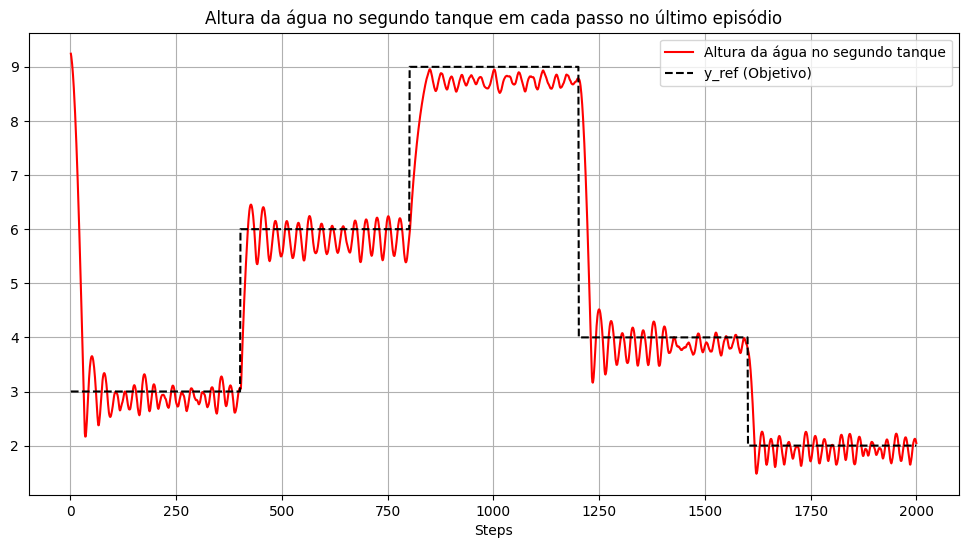

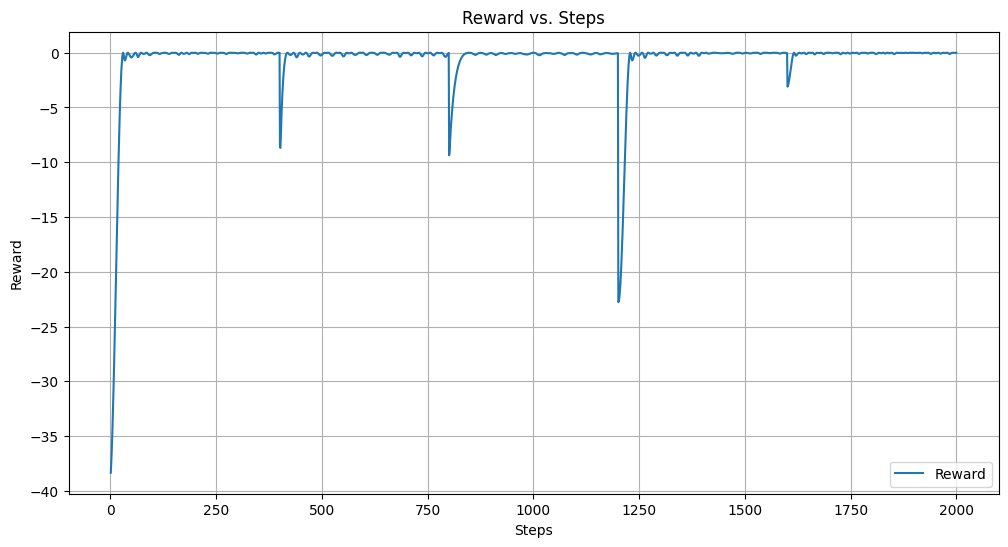

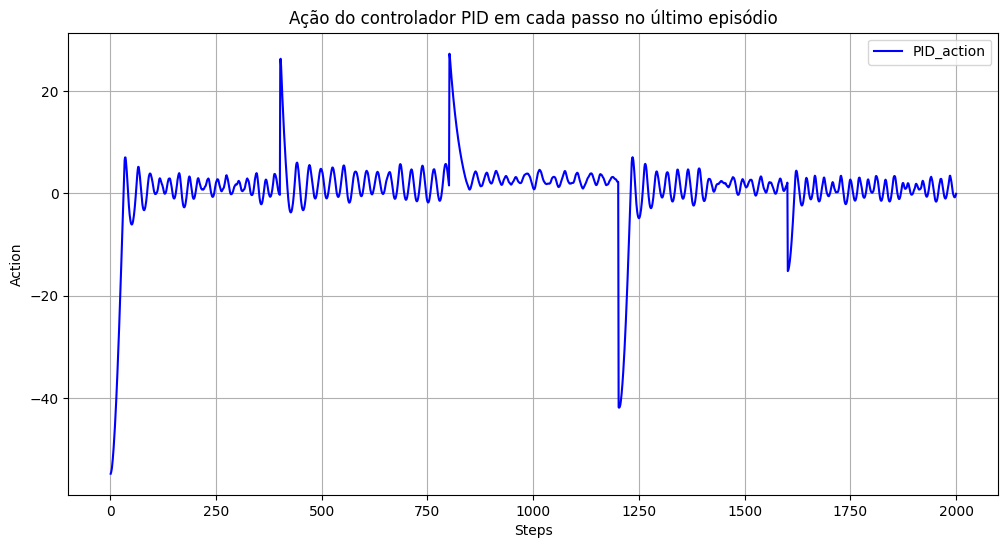

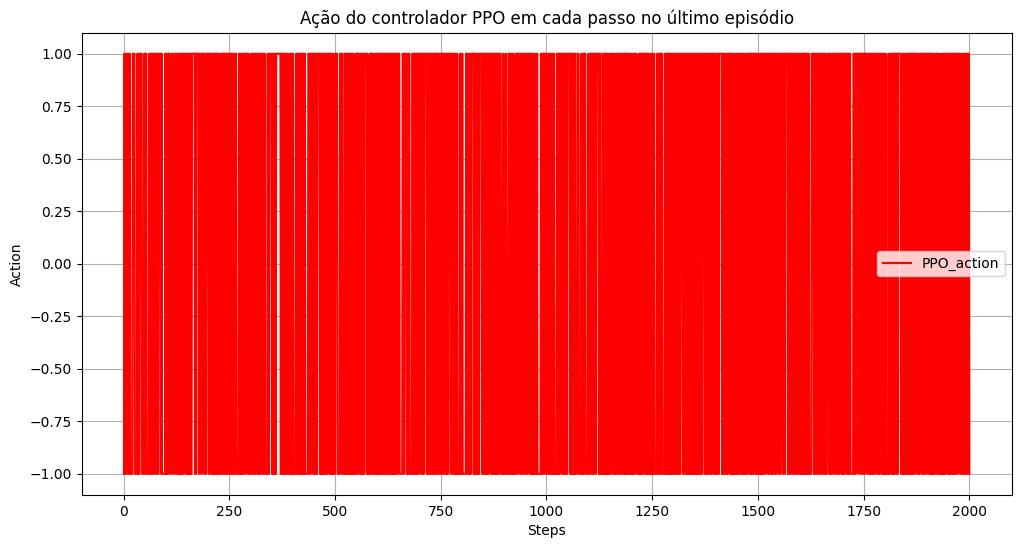

In [130]:
import ipywidgets as widgets
from ipywidgets import GridBox, Button
from IPython.display import display, clear_output

# Função para exibir a grade de pastas
def display_folders_grid(folder_names: list[str], 
                         selected_indices: list[int] = 0
                         ) -> GridBox:
    num_cols = 5
    # num_rows = (len(folder_names) + num_cols - 1) // num_cols
    previous_selected = [selected_indices]
    
    def on_button_click(b: Button):
        global selected_folder
        selected_folder = b.description

        global progress_df, rec_df, last_episode_df
        progress_df, rec_df, last_episode_df = load_dfs(selected_folder)

        previous_selected.append(buttons.index(b))
        if len(previous_selected) > 2:
            previous_selected.pop(0)
        
        # Atualiza cor dos botões
        buttons[previous_selected[0]].button_style = '' 
        buttons[previous_selected[1]].button_style = 'success'

        clear_output(wait=True)  # Limpar as saídas anteriores
        display(grid)            # Reexibir a grade de botões

        plot_tracking(selected_folder, save=False)
        plot_rewards(selected_folder, save=False)
        plot_action_per_steps(selected_folder, save=False)
        # plot_progress(selected_folder, save=False)
    
    # Criar os botões
    buttons = []
    for i, folder in enumerate(folder_names):
        button = widgets.Button(description=folder, 
                                layout=widgets.Layout(width='auto', height='auto'), 
                                index=i
                                )
        button.on_click(on_button_click)
        
        buttons.append(button)
    
    buttons[selected_indices].button_style = 'success'  # Definir a cor do botão selecionado como verde
    
    grid = widgets.GridBox(
        children=buttons,
        layout=widgets.Layout(grid_template_columns=f'repeat({num_cols}, 1fr)')
    )
    display(grid)
    return grid

# Exibir a grade de pastas
grid = display_folders_grid(folder_names, selected_index)